<center><img src="https://i.imgur.com/gE3PMKU.jpg" width="500px"></center>


In [1]:
!pip install imbalanced-learn

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
from tqdm import tqdm
import pandas as pd
import cv2
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [3]:
train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [4]:
test = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Test Images:

## Malignent:

In [5]:
# malignant = test[test['benign_malignant']=='malignant']
# malignant_vals = malignant['image_name'].values
# type(malignant_vals)
# len(malignant_vals)

## Malignent :

In [6]:
malignant = train[train['benign_malignant']=='malignant']
malignant_vals = malignant['image_name'].values
type(malignant_vals)
len(malignant_vals)

584

In [7]:
malignant_labels = malignant['target'].values
malignant_labels_rand = [np.random.choice(malignant_labels) for i in range(584)]

In [8]:
malignant_list = list(malignant_vals)
type(malignant_list)
len(malignant_list)
# malignant_list
#malignant_rand = [np.random.choice(malignant_vals + '.jpg') for i in range(584)]

584

In [9]:
# DIR = '../input/siim-isic-melanoma-classification/jpeg/train'
# benign_images = []

# for i in malignant_rand:
#     image1 = plt.imread(os.path.join(DIR,i))
#     image1 = cv2.resize(image1,(224,224))
#     benign_images.append(image1)
# #     np.append(k_be,image1)


## Benign :

In [10]:
benign = train[train['benign_malignant']=='benign']
benign_vals = benign['image_name'].values
type(benign_vals)
len(benign_vals)

32542

In [11]:
benign_labels = benign['target'].values
benign_labels_rand = [np.random.choice(benign_labels) for i in range(584)]

In [12]:
benign_list = list(benign_vals)
type(benign_list)
# benign_rand = [np.random.choice(benign_vals + '.jpg') for i in range(584)]

list

In [13]:
benign_list_1 = benign_list[0:584]
len(benign_list_1)

584

## COMBINING MAL & BNIN `IMAGE_NAME` LISTS:

In [14]:
mal_bin_cmbo_img_name_list = malignant_list + benign_list_1
mal_bin_cmbo_label_list = malignant_labels_rand + benign_labels_rand
print(len(mal_bin_cmbo_label_list))
print(len(mal_bin_cmbo_img_name_list))

1168
1168


## TRAIN & VALIDATION SPLIT

In [15]:
# SEED = 42
# from sklearn.model_selection import train_test_split
# x_train,x_val,y_train,y_val = train_test_split(mal_bin_cmbo_img_name_list,mal_bin_cmbo_label_list,test_size = 0.2,random_state = SEED)

## READING THE COMBINED IMAGES AND STORING INTO A LIST

In [16]:
import gc
gc.collect()

104

In [17]:
DIR = '../input/siim-isic-melanoma-classification/jpeg/train'
img_data = []
jpeg = '.jpg'
img_size = 224

for i in tqdm(mal_bin_cmbo_img_name_list):
    img = plt.imread(os.path.join(DIR,i)+jpeg)
    img = cv2.resize(img,(img_size,img_size))
    img_data.append(img)

100%|██████████| 1168/1168 [08:26<00:00,  2.31it/s]


In [18]:
train_imgs = np.asarray(img_data)
print(train_imgs.shape)
train_labels =  np.asarray(mal_bin_cmbo_label_list)
# test_imgs = np.asarray(test_imgs)
# test_labels =  np.asarray(test_labels)

(1168, 224, 224, 3)


In [19]:
BATCH_SIZE = 64
SEED = 42
EPOCHS = 100
x, y, z = 224, 224, 3
inputShape = (x, y, z)
NUM_CLASSES = 1

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(
    train_imgs, 
    train_labels,
    test_size = 0.3, 
    random_state = SEED
)

In [21]:
type(X_val)

numpy.ndarray

In [22]:
train_datagen = ImageDataGenerator( rescale = 1./255,
                                    rotation_range=90,
                                    width_shift_range=0.15,
                                    height_shift_range=0.15,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    zoom_range=(0.9,1),
                                    fill_mode= 'nearest',
                                    brightness_range=(0.8, 1.2),
                                  )

train_generator = train_datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE)
val_generator = train_datagen.flow(X_val, Y_val, batch_size = BATCH_SIZE, shuffle = True)

## Model Building:

In [23]:
import matplotlib.pyplot as plt
from glob import glob
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
import keras
import numpy as np

from keras.models import Sequential
from keras.layers import (  Dense,
                            Flatten,
                            LeakyReLU
                         )
from keras.applications import  VGG19 
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from skimage.transform import resize
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator

In [24]:
from keras.callbacks import ModelCheckpoint
filepath = "../working/saved_models-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor = 'val_acc',verbose = 1,save_best_only = True,mode = 'max')
callbacks_list = [checkpoint]

In [25]:
model = Sequential()
model.add(VGG19(include_top=False, weights='imagenet', input_shape= inputShape))
model.add(Flatten())
model.add(Dense(32))
model.add(LeakyReLU(0.001))
model.add(Dense(16))
model.add(LeakyReLU(0.001))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].trainable = False

model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['acc'])

History = model.fit_generator(train_generator,
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    epochs = EPOCHS, 
    validation_data = val_generator,
    validation_steps = len(X_val) // BATCH_SIZE,
    callbacks = callbacks_list
)


model.save('melanoma-classification-model.h5')

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/100
12/12 [==============================] - 19s 2s/step - loss: 0.7505 - acc: 0.5166 - val_loss: 0.6676 - val_acc: 0.5969

Epoch 00001: val_acc improved from -inf to 0.59688, saving model to ../working/saved_models-improvement-01-0.60.hdf5
Epoch 2/100
12/12 [==============================] - 15s 1s/step - loss: 0.6520 - acc: 0.6029 - val_loss: 0.6138 - val_acc: 0.6446

Epoch 00002: val_acc improved from 0.59688 to 0.64460, saving model to ../working/saved_models-improvement-02-0.64.hdf5
Epoch 3/100
12/12 [==============================] - 16s 1s/step - loss: 0.5965 - acc: 0.6786 - val_loss: 0.5710 - val_acc: 0.5958

Epoch 00003: val_acc did not improve from 0.64460
Epoch 4/100
12/12 [==============================] - 14s 1s/step - loss: 0.5969 - acc: 0.6641 - val_loss: 0.6326 - val_acc: 0.6376

Epoch 00004: val_acc did not improve from 0.64460
Epoch 5/100
12/12 [==============================] - 13s 1s/step - los

In [26]:
# model.save('melanoma-classification-model.h5')

## Ploting the results of the training:

In [27]:
def hist(History):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    ax[0].plot(History.history['loss'])
    ax[0].plot(History.history['val_loss'])
    ax[0].legend(['Training loss', 'Validation Loss'],fontsize=18)
    ax[0].set_xlabel('Epochs ',fontsize=16)
    ax[0].set_ylabel('Loss',fontsize=16)
    ax[0].set_title('Training loss x Validation Loss',fontsize=16)


    ax[1].plot(History.history['acc'])
    ax[1].plot(History.history['val_acc'])
    ax[1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    ax[1].set_xlabel('Epochs ',fontsize=16)
    ax[1].set_ylabel('Accuracy',fontsize=16)
    ax[1].set_title('Training Accuracy x Validation Accuracy',fontsize=16)

In [28]:
def plot_any(arr, title = ''):
    plt.figure(figsize = (15, 25))
    for i in range(len(arr)):
        plt.subplot(1,len(arr),i + 1)
        plt.title(title)
        plt.imshow(arr[i], cmap = 'gray');

In [29]:
loss, accu = model.evaluate(X_val, Y_val)
print("%s: %.2f%%" % ('Accuracy...', accu))
print("%s: %.2f" % ('loss.......', loss))

351/351 [==============================] - 2s 5ms/step
Accuracy...: 0.65%
loss.......: 7.71


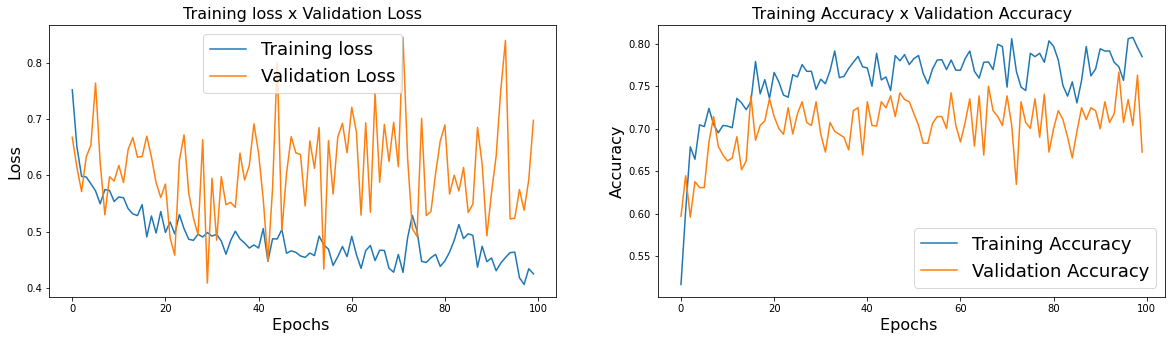

In [30]:
hist(History)

## Making Submission:

In [31]:
from keras.models import load_model
previous_model = load_model('../working/melanoma-classification-model.h5')

In [32]:
testimg_dir = test['image_name'].values
testimg_dir = list(testimg_dir)
# testimg_dir

In [33]:
submission=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')
submission.head()

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0


In [34]:
DIR1 = '../input/siim-isic-melanoma-classification/jpeg/test'
target=[]
for i in tqdm(testimg_dir):
    img=cv2.imread(os.path.join(DIR1,i)+jpeg)
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    img=np.reshape(img,(1,224,224,3))
    prediction=previous_model.predict(img)
    target.append(prediction[0][0])

submission['target']=target

100%|██████████| 10982/10982 [28:26<00:00,  6.44it/s]


In [35]:
submission.to_csv('submission.csv', index=False)
submission.head()

,image_name,target
0,ISIC_0052060,0.015126
1,ISIC_0052349,0.012018
2,ISIC_0058510,0.017625
3,ISIC_0073313,0.016581
4,ISIC_0073502,0.764647


As you can see, in this note book I have taken 584 images from each class(because the both the classes are highly imbalanced), then applied image augmentation on the fly. If we do the image augmentation without doing that image will increase for sure, but it will not resolve the problem of imbalance class.

In [36]:
# !pip install Keras

In [37]:
# from keras.layers import Input,Dense,Flatten
# from keras.models import Model
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input
# from keras.preprocessing import image
# from keras.preprocessing.image import ImageDataGenerator
# from keras.models import Sequential
# from glob import glob

In [38]:
# vgg = VGG16(input_shape = inputShape,weights = 'imagenet',include_top = False)

In [39]:
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')

In [40]:
# from skimage.io import imread
# from skimage.color import rgb2gray
# from skimage.transform import resize

# train_imgs = []
# train_labels = []
# test_imgs  = []
# test_labels = []

# x, y, z = 224, 224, 3

# #train

# for i in malignant_rand:
#     img_resize = imread(os.path.join(DIR,i))
#     img_resize = resize(img_resize, (x, y, z))

#     train_imgs.append(img_resize)
# #     train_labels.append(klass)
        
# #test
# # for klass, folder in enumerate(tqdm(test_path)):
# #     for img in glob(folder + '/*'):
        
# #         img_resize = imread(img)
# #         img_resize = resize(img_resize, (x, y, z))

# #         test_imgs.append(img_resize)
# #         test_labels.append(klass)

In [41]:
# train_imgs[0].shape

In [42]:
# train_imgs = np.asarray(train_imgs)

In [43]:
# train_imgs.shape

In [44]:
#I can take two list of benign_rand and malignent_rand and concat them then do the for loop for reading the images and store into a new list
#then convert that list into a nparray
# then follow 'https://www.kaggle.com/xwalker/simple-cnn-vgg19-keras'
# NUM_CLASSES = 1
# EPOCHS = 15
# BATCH_SIZE = 64
# inputShape = (x, y, z)
# X_train, X_test, y_train, y_test = train_test_split(
#     train_imgs, 
#     train_labels,
#     test_size = 0.3, 
# )
# train_datagen = ImageDataGenerator( rescale = 1./255,
#                                     rotation_range=90,
#                                     width_shift_range=0.15,
#                                     height_shift_range=0.15,
#                                     horizontal_flip = True,
#                                     vertical_flip = True,
#                                     zoom_range=(0.9,1),
#                                     fill_mode= 'nearest',
#                                     brightness_range=(0.8, 1.2),
#                                   )

# train_generator = train_datagen.flow(X_train, y_train, batch_size = BATCH_SIZE)
# val_generator = train_datagen.flow(X_test, y_test, batch_size = BATCH_SIZE, shuffle = True)

In [45]:
# concated_be_mal = benign_rand + malignant_rand
# concated_be_mal_1 = [np.random.choice(concated_be_mal)]


In [46]:
# plt.imshow(benign_images[9])

In [47]:
# for i in benign_images:
#     benign_images_1 = np.asarray(i)
    

In [48]:
# plt.imshow(benign_images_1[9])

In [49]:
# benign_images1[0]

In [50]:
# from keras.preprocessing.image import image to array

In [51]:
# from tqdm import tqdm

# DIR = '../input/siim-isic-melanoma-classification/jpeg/train'
# jpeg = '.jpg'
# labels = []
# images = []


# directory = []
# for i in train['image_name']:
#     directory.append(os.path.join(DIR,i)+jpeg)

# for i in range(train.shape[0]):
#     labels.append(train['target'])
    
# for i in tqdm(range(0,train.shape[0],32)):
#     imag = plt.imread(directory[i])
#     imag = imag/255.0
#     imag = cv2.resize(imag,(256,256))
#     images.append(imag)

In [52]:
# img_data = np.reshape(images,(images.shape[0],img_size,img_size,3))
# label_data = np.array(labels)

In [53]:
# plt.imshow(images[64])

In [54]:
# 1036*32


In [55]:
# directory[9]

In [56]:
# im = cv2.imread(directory[9])
# im = cv2.resize(im,(256,256))
# im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
# plt.imshow(im)
# print(im.shape)

In [57]:
# import gc
# gc.collect()

In [58]:
# class BalancedDataGenerator(Sequence):
#     """ImageDataGenerator + RandomOversampling"""
#     def __init__(self, x, y, datagen, batch_size=32):
#         self.datagen = datagen
#         self.batch_size = batch_size
#         self._shape = x.shape        
#         datagen.fit(x)
#         self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)

#     def __len__(self):
#         return self._shape[0] // self.batch_size

#     def __getitem__(self, idx):
#         x_batch, y_batch = self.gen.__next__()
#         x_batch = x_batch.reshape(-1, *self._shape[1:])
#         return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [59]:
# from keras.preprocessing.Image import ImageDataGenerator
# datagen = ImageDataGenerator() # define your data augmentation
# bgen = BalancedDataGenerator(x, y, datagen, batch_size=32)
# steps_per_epoch = balanced_gen.steps_per_epoch

In [60]:
# import gc
# gc.collect()